## Singapore Rainfall data for the location (1.30◦N,103.68◦E), collected in year 2010 from ground-based weather station.
Exploratory analysis - Initial Ploting and Data Parsing.

In [16]:
%matplotlib inline
from glob import glob # For selecting multiple filenames
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import xarray as xr
import seaborn as sns # for density plots
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# from datetime import datetime
style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (16,5) # For Increasing Size of graph

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Data Importing
---

In [4]:
# Dataframe for IMAGER data
imager_rainfall_df = pd.read_csv("data/imagerdata.csv", header=None, names=["day", "hour", "minute", "rainfall_rate"])
chirps_dataset = xr.open_dataset('data/chirps-2010.nc') # open the dataset using xarray

In [5]:
# Import using glob
filenames = glob("data/daily_*.csv")
gauge_station_df = pd.concat([pd.read_csv(filename, encoding= 'unicode_escape') for filename in filenames], axis=0)
gauge_station_df.drop(['Station','Highest 30 Min Rainfall (mm)', 
                       'Highest 60 Min Rainfall (mm)', 
                       'Highest 120 Min Rainfall (mm)', 
                       'Mean Wind Speed (km/h)', 
                       'Max Wind Speed (km/h)', 
                       'Mean Temperature (°C)', 
                       'Minimum Temperature (°C)', 
                       'Maximum Temperature (°C)'], axis=1, inplace=True) # Dropped the day, hour, minute columns
gauge_station_df.tail()

,Year,Month,Day,Daily Rainfall Total (mm)
26,2010,1,27,0.0
27,2010,1,28,0.0
28,2010,1,29,0.4
29,2010,1,30,2.1
30,2010,1,31,0.0


### Parsing the Gauge Station Data for JANUARY 2010

Parse Year, Month and day. Convert to datetime. Set tindex to timestamp. Drop Year, Month and Day columns. Rename the column

In [6]:
# Semicolon is used to separate month and day, otherwise datetime is wrongly converted
gauge_station_df['timestamp'] = pd.to_datetime(gauge_station_df['Year'].astype(str) + gauge_station_df['Month'].astype(str) + ":"+ gauge_station_df['Day'].astype(str), format="%Y%m:%d")
gauge_station_df.set_index('timestamp', inplace=True)
gauge_station_df.drop(['Year', 'Month', 'Day'], inplace=True, axis=1)
gauge_station_df.sort_index(axis=0)
gauge_station_df.rename(columns={'Daily Rainfall Total (mm)':'total_rainfall'}, inplace=True)
gauge_station_df.head()

,total_rainfall
timestamp,
2010-07-01,104.2
2010-07-02,18.4
2010-07-03,34.8
2010-07-04,0.0
2010-07-05,0.0


### Parsing the CHIRPS dataset for JANUARY 2010

In [7]:
# Dataframe for CHIRPS Dataset
chirps_df = chirps_dataset['precip'].sel(time=slice('2010-01-01T00:0','2010-01-31T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()
monsoon_chirps_df = chirps_dataset['precip'].sel(time=slice('2010-06-01T00:0','2010-09-30T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()

### Parsing the IMAGER dataset

In [8]:
# Parsing the Dates
imager_rainfall_df['date']=pd.to_datetime(imager_rainfall_df['day'], unit='D', origin=pd.Timestamp('2009-12-31')) # Using day number to create the date
imager_rainfall_df['timestamp'] = imager_rainfall_df['date'] + pd.to_timedelta(imager_rainfall_df['hour'].astype('str') + ':' + imager_rainfall_df['minute'].astype('str') + ':00') # append the timedelta in hours and minutes to get the full timestamp
imager_rainfall_df.set_index('timestamp', inplace=True)

In [9]:
imager_sampled_df = pd.DataFrame()
imager_sampled_df = imager_rainfall_df.groupby(pd.Grouper(freq="M")).resample('D').sum() # Groupby MONTH and then taking the total daily sum
imager_sampled_df.drop(['day', 'hour', 'minute'], axis=1, inplace=True) # Dropped the day, hour, minute columns
imager_sampled_df = imager_sampled_df.reset_index(level=0, drop=True)
imager_sampled_df.head() # Imager Data after resampling

,rainfall_rate
timestamp,
2010-01-01,1080
2010-01-02,12
2010-01-03,12
2010-01-04,792
2010-01-05,0


In [10]:
def plot_monthly_data():
    titles = ["January 2010", "February 2010", "March 2010", "April 2010", "May 2010", "June 2010", "July 2010", "August 2010", "September 2010", "October 2010", "November 2010", "December 2010"]
    for i in range(1, 13):
        plt.figure()
        plt.plot(sampled_df[sampled_df.index.month == i]['rainfall_rate'])
        plt.title(titles[i-1], loc='left')
        plt.xlabel('Timestamp')
        plt.ylabel('Rainfall Rate in ')
        # Show/save figure as desired.
        plt.show()
# plot_monthly_data()

### Basic data analysis for the IMAGER data

In [11]:
daily_statistics_df = pd.DataFrame()
monthly_statistics_df = pd.DataFrame()
daily_statistics_df['daily_total_rate'] = rainfall_df.rainfall_rate.resample('D').sum()
daily_statistics_df['daily_mean_rate'] = rainfall_df.rainfall_rate.resample('D').mean()
monthly_statistics_df['monthly_total_rate'] = rainfall_df.rainfall_rate.resample('M').sum()
monthly_statistics_df['monthly_mean_rate'] = rainfall_df.rainfall_rate.resample('M').mean()

NameError: name 'rainfall_df' is not defined

In [12]:
plt.plot(monthly_statistics_df['monthly_mean_rate'] )
plt.title("Monthly Mean rainfall from IMAGER, 2010", loc='left')
plt.xlabel('Timestamp')
plt.ylabel('Mean Rainfall')
ax = plt.gca()
locator = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(month_fmt)

KeyError: 'monthly_mean_rate'

## January Rainfall Comparison with Gauge Station Data
Taken from - www.weather.gov.sg/climate-historical-daily/

NOTE : The Imager Raifall Column is divided by 100, in order to fit it with Gauge Station Data. After knowing the actual units of the data it would be corrected.

In [14]:
# Separate Dataframes for January
imager_jan = imager_sampled_df.loc[imager_sampled_df.index.month == 1]/100
gauge_jan = gauge_station_df.loc[gauge_station_df.index.month == 1]

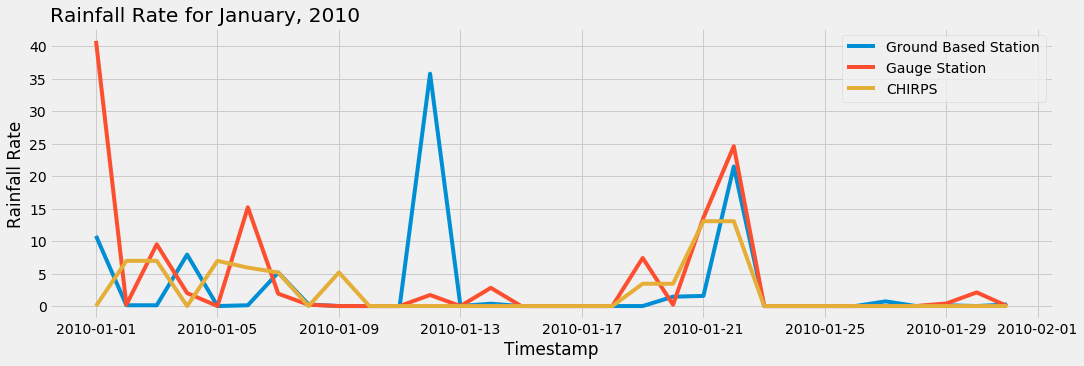

In [21]:
plt.plot(imager_jan['rainfall_rate'], label='Ground Based Station')
plt.plot(gauge_jan['total_rainfall'], label='Gauge Station')
plt.plot(chirps_df['precip'], label='CHIRPS')
plt.title('Rainfall Rate for January, 2010', loc='left')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Rainfall Rate');

## Monsoon Season Analysis -
According to [this](https://www.guidemesingapore.com/business-guides/immigration/get-to-know-singapore/weather-and-climate-in-singapore),
There is no clear-cut wet or dry season and rain is experienced every single month, usually in the afternoons and early evenings. However, there are two main monsoon seasons in Singapore: **Northeast Monsoon Season (December-March) and the Southwest Monsoon Season (June-September)**.

In [22]:
monsoon_imager = imager_sampled_df[(imager_sampled_df.index.month >= 6) & (imager_sampled_df.index.month <= 9)]/100
monsoon_gauge = gauge_station_df[(gauge_station_df.index.month >= 6) & (gauge_station_df.index.month <= 9)]
monsoon_gauge = monsoon_gauge.sort_index(axis=0)
monsoon_gauge.head()

,total_rainfall
timestamp,
2010-06-01,8.8
2010-06-02,0.0
2010-06-03,0.0
2010-06-04,0.4
2010-06-05,11.6


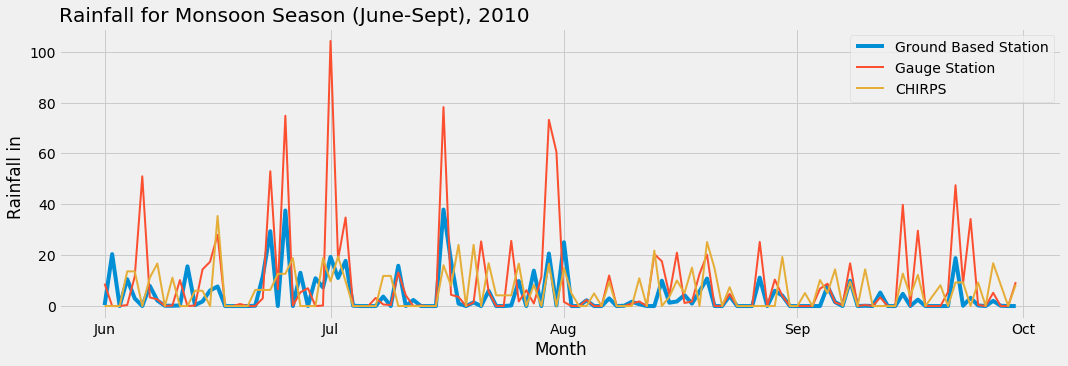

In [23]:
plt.plot(monsoon_imager['rainfall_rate'], label='Ground Based Station')
plt.plot(monsoon_gauge['total_rainfall'], linewidth=2, label='Gauge Station')
plt.plot(monsoon_chirps_df['precip'], label='CHIRPS', linewidth=2)
plt.title('Rainfall for Monsoon Season (June-Sept), 2010', loc='left')
plt.xlabel("Month")
plt.ylabel("Rainfall in ")
ax = plt.gca()
locator = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(month_fmt)
plt.legend();

The points are more or less aligned, therefore the IMAGER is giving good aproximates for larger amount of rainfall. It will be more coherant when the units of IMAGER is known.

### Monsoon Season Comparison Distribution Plot

In [ ]:
sns.distplot(monsoon_gauge['total_rainfall'], hist=True, kde=True, label='Gauge Station')
sns.distplot(monsoon_chirps_df['precip'], hist=True, kde=True, label='CHIRPS')
sns.distplot(monsoon_imager['rainfall_rate'], hist=True, kde=True, label='IMAGER')
plt.legend()
plt.title('Monsoon Season Distribution Plot, 2010', loc="left")
plt.xlabel("Rainfall");

In [ ]:
# corr = monsoon_gauge['rainfall'].corr(monsoon_precip_df['precip'], method='pearson')
# corr

In [ ]:
# chirps_mean = precip_dataset['precip'].sel(time=slice('2010-01-01T00:0','2010-12-31T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()